In [1]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(readr)
library(stats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Load the data
case_data <- read_csv('PC_case.csv', col_names = FALSE)
control_data <- read_csv('PC_control.csv', col_names = FALSE)
gene_list <- read_csv('geneList.csv', col_names = FALSE)

Rows: 11564 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): X1, X4, X5
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 32449 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): X1, X4, X5
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 59110 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): X1, X3
dbl (3): X2, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Rename columns for clarity
colnames(case_data) <- c('Chromosome', 'Start', 'End', 'Type', 'Patient_ID')
colnames(control_data) <- c('Chromosome', 'Start', 'End', 'Type', 'Patient_ID')
colnames(gene_list) <- c('Gene_ID', 'Unused', 'Chromosome', 'Gene_Start', 'Gene_End')

In [4]:
# Drop unused column in gene_list
gene_list <- gene_list %>% select(-Unused)

In [5]:
# Group case and control data by chromosomal regions
case_regions <- case_data %>%
  group_by(Chromosome, Start, End, Type) %>%
  summarise(Case_Count = n(), .groups = 'drop')

control_regions <- control_data %>%
  group_by(Chromosome, Start, End, Type) %>%
  summarise(Control_Count = n(), .groups = 'drop')

In [6]:
# Merge case and control regions
merged_regions <- full_join(case_regions, control_regions, by = c('Chromosome', 'Start', 'End', 'Type')) %>%
  replace_na(list(Case_Count = 0, Control_Count = 0))

In [7]:
# Calculate total case and control patient counts
total_case_patients <- n_distinct(case_data$Patient_ID)
total_control_patients <- n_distinct(control_data$Patient_ID)

In [8]:
# Perform Fisher's exact test
fisher_test <- function(case_count, control_count, total_case, total_control) {
  case_absence <- total_case - case_count
  control_absence <- total_control - control_count
  contingency_table <- matrix(c(case_count, control_count, case_absence, control_absence), nrow = 2)
  p_val <- fisher.test(contingency_table, alternative = "greater")$p.value
  return(p_val)
}

merged_regions <- merged_regions %>%
  rowwise() %>%
  mutate(P_Value = fisher_test(Case_Count, Control_Count, total_case_patients, total_control_patients))

In [9]:
# Filter significant regions
significant_regions <- merged_regions %>%
  filter(P_Value < 0.05)

In [10]:
# Map significant regions to genes
map_to_genes <- function(chromosome, start, end, genes) {
  overlapping_genes <- genes %>%
    filter(Chromosome == paste0('chr', chromosome),
           Gene_End >= start,
           Gene_Start <= end)
  paste(overlapping_genes$Gene_ID, collapse = ";")
}

significant_regions <- significant_regions %>%
  rowwise() %>%
  mutate(Associated_Genes = map_to_genes(Chromosome, Start, End, gene_list))

In [11]:
# Save results to a CSV file
write_csv(significant_regions, 'Significant_Regions_with_Genes.csv')

# Print completion message
print("Significant regions with associated genes saved to 'Significant_Regions_with_Genes.csv'.")

[1] "Significant regions with associated genes saved to 'Significant_Regions_with_Genes.csv'."


In [12]:
# Visualizations
library(ggplot2)

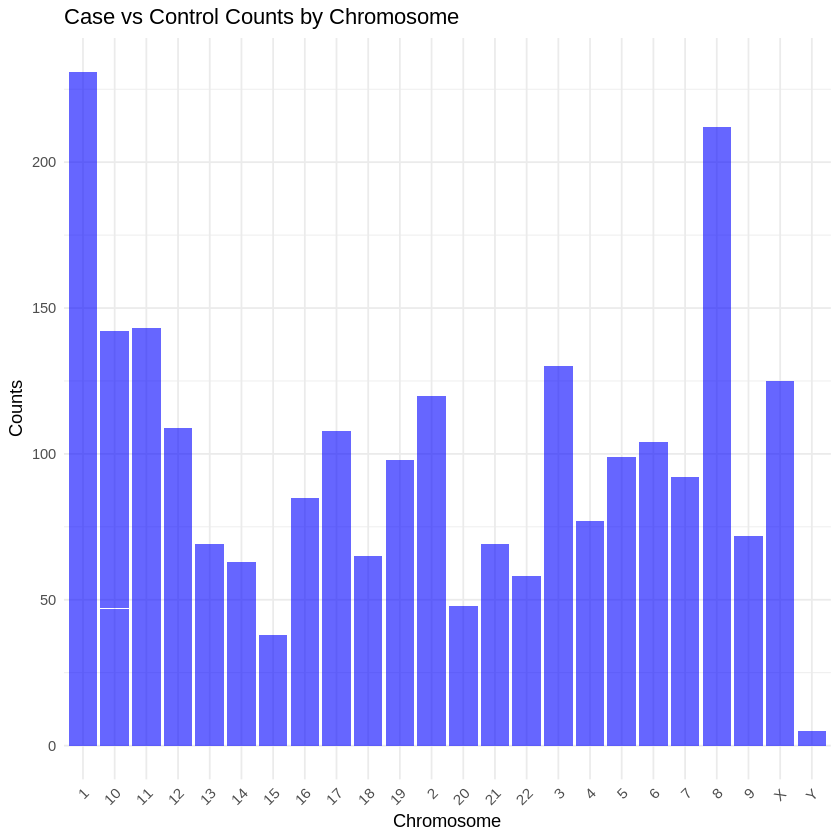

In [13]:
# Bar Plot: Case vs Control Counts
ggplot(significant_regions, aes(x = Chromosome)) +
  geom_bar(aes(y = Case_Count), stat = "identity", fill = "blue", alpha = 0.6) +
  geom_bar(aes(y = Control_Count), stat = "identity", fill = "orange", alpha = 0.6) +
  labs(title = "Case vs Control Counts by Chromosome", y = "Counts", x = "Chromosome") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

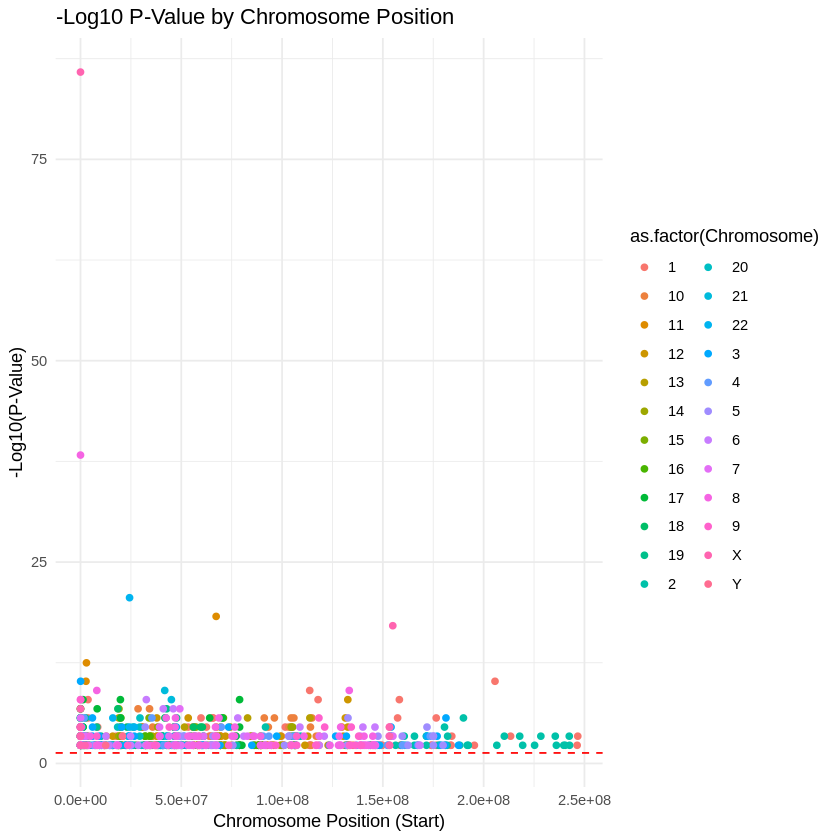

In [14]:
# Scatter Plot: Chromosome Position vs P-Value
significant_regions <- significant_regions %>%
  mutate(Log_P_Value = -log10(P_Value))

ggplot(significant_regions, aes(x = Start, y = Log_P_Value, color = as.factor(Chromosome))) +
  geom_point() +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
  labs(title = "-Log10 P-Value by Chromosome Position", y = "-Log10(P-Value)", x = "Chromosome Position (Start)") +
  theme_minimal()
